# Colab FAQ

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

You need to use the colab GPU for this assignmentby selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

# Setup PyTorch
All files are stored at /content/csc421/a4/ folder


In [ ]:
######################################################################
# Setup python environment and change the current working directory
######################################################################
!pip install torch torchvision
!pip install imageio

!pip install matplotlib

%mkdir -p /content/csc413/a4/
%cd /content/csc413/a4

/content/csc413/a4


# Helper code

## Utility functions

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from six.moves.urllib.request import urlretrieve
import tarfile

import imageio
from urllib.error import URLError
from urllib.error import HTTPError


def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)

    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    return fpath


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def to_var(tensor, cuda=True):
    """Wraps a Tensor in a Variable, optionally placing it on the GPU.

        Arguments:
            tensor: A Tensor object.
            cuda: A boolean flag indicating whether to use the GPU.

        Returns:
            A Variable object, on the GPU if cuda==True.
    """
    if cuda:
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()


def create_dir(directory):
    """Creates a directory if it doesn't already exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)


def gan_checkpoint(iteration, G, D, opts):
    """Saves the parameters of the generator G and discriminator D.
    """
    G_path = os.path.join(opts.checkpoint_dir, 'G.pkl')
    D_path = os.path.join(opts.checkpoint_dir, 'D.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def load_checkpoint(opts):
    """Loads the generator and discriminator models from checkpoints.
    """
    G_path = os.path.join(opts.load, 'G.pkl')
    D_path = os.path.join(opts.load, 'D_.pkl')

    G = DCGenerator(noise_size=opts.noise_size, conv_dim=opts.g_conv_dim, spectral_norm=opts.spectral_norm)
    D = DCDiscriminator(conv_dim=opts.d_conv_dim)

    G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
    D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))

    if torch.cuda.is_available():
        G.cuda()
        D.cuda()
        print('Models moved to GPU.')

    return G, D


def merge_images(sources, targets, opts):
    """Creates a grid consisting of pairs of columns, where the first column in
    each pair contains images source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """
    _, _, h, w = sources.shape
    row = int(np.sqrt(opts.batch_size))
    merged = np.zeros([3, row * h, row * w * 2])
    for (idx, s, t) in (zip(range(row ** 2), sources, targets, )):
        i = idx // row
        j = idx % row
        merged[:, i * h:(i + 1) * h, (j * 2) * h:(j * 2 + 1) * h] = s
        merged[:, i * h:(i + 1) * h, (j * 2 + 1) * h:(j * 2 + 2) * h] = t
    return merged.transpose(1, 2, 0)


def generate_gif(directory_path, keyword=None):
    images = []
    for filename in sorted(os.listdir(directory_path)):
        if filename.endswith(".png") and (keyword is None or keyword in filename):
            img_path = os.path.join(directory_path, filename)
            print("adding image {}".format(img_path))
            images.append(imageio.imread(img_path))

    if keyword:
        imageio.mimsave(
            os.path.join(directory_path, 'anim_{}.gif'.format(keyword)), images)
    else:
        imageio.mimsave(os.path.join(directory_path, 'anim.gif'), images)


def create_image_grid(array, ncols=None):
    """
    """
    num_images, channels, cell_h, cell_w = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h * nrows, cell_w * ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w, :] = array[i * ncols + j].transpose(1, 2,
                                                                                                                 0)

    if channels == 1:
        result = result.squeeze()
    return result


def gan_save_samples(G, fixed_noise, iteration, opts):
    generated_images = G(fixed_noise)
    generated_images = to_data(generated_images)

    grid = create_image_grid(generated_images)

    # merged = merge_images(X, fake_Y, opts)
    path = os.path.join(opts.sample_dir, 'sample-{:06d}.png'.format(iteration))
    imageio.imwrite(path, grid)
    print('Saved {}'.format(path))

## Data loader

In [ ]:
def get_emoji_loader(emoji_type, opts):
    """Creates training and test data loaders.
    """
    transform = transforms.Compose([
                    transforms.Scale(opts.image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])

    train_path = os.path.join('data/emojis', emoji_type)
    test_path = os.path.join('data/emojis', 'Test_{}'.format(emoji_type))

    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    train_dloader = DataLoader(dataset=train_dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.num_workers)
    test_dloader = DataLoader(dataset=test_dataset, batch_size=opts.batch_size, shuffle=False, num_workers=opts.num_workers)

    return train_dloader, test_dloader

## Training and evaluation code

In [ ]:
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                 G                     ")
    print("---------------------------------------")
    print(G_XtoY)
    print("---------------------------------------")

    print("                  D                    ")
    print("---------------------------------------")
    print(D_X)
    print("---------------------------------------")


def create_model(opts):
    """Builds the generators and discriminators.
    """
    ### GAN
    G = DCGenerator(noise_size=opts.noise_size, conv_dim=opts.g_conv_dim, spectral_norm=opts.spectral_norm)
    D = DCDiscriminator(conv_dim=opts.d_conv_dim, spectral_norm=opts.spectral_norm)

    print_models(G, None, D, None)

    if torch.cuda.is_available():
        G.cuda()
        D.cuda()
        print('Models moved to GPU.')
    return G, D

def train(opts):
    """Loads the data, creates checkpoint and sample directories, and starts the training loop.
    """

    # Create train and test dataloaders for images from the two domains X and Y
    dataloader_X, test_dataloader_X = get_emoji_loader(emoji_type=opts.X, opts=opts)

    # Create checkpoint and sample directories
    create_dir(opts.checkpoint_dir)
    create_dir(opts.sample_dir)

    # Start training
    if opts.least_squares_gan:
        G, D = gan_training_loop_leastsquares(dataloader_X, test_dataloader_X, opts)
    else:
        G, D = gan_training_loop_regular(dataloader_X, test_dataloader_X, opts)

    return G, D

def print_opts(opts):
    """Prints the values of all command-line arguments.
    """
    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        if opts.__dict__[key]:
            print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)


# Your code for generators and discriminators

## Helper modules

In [ ]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.

    Output:
    - A PyTorch Tensor of shape (batch_size, dim, 1, 1) containing uniform
      random noise in the range (-1, 1).
    """
    return to_var(torch.rand(batch_size, dim) * 2 - 1).unsqueeze(2).unsqueeze(3)


def upconv(in_channels, out_channels, kernel_size, stride=2, padding=2, batch_norm=True, spectral_norm=False):
    """Creates a upsample-and-convolution layer, with optional batch normalization.
    """
    layers = []
    if stride>1:
        layers.append(nn.Upsample(scale_factor=stride))
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False)
    if spectral_norm:
        layers.append(SpectralNorm(conv_layer))
    else:
        layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)


def conv(in_channels, out_channels, kernel_size, stride=2, padding=2, batch_norm=True, init_zero_weights=False, spectral_norm=False):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    if init_zero_weights:
        conv_layer.weight.data = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.001

    if spectral_norm:
        layers.append(SpectralNorm(conv_layer))
    else:
        layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)


class ResnetBlock(nn.Module):
    def __init__(self, conv_dim):
        super(ResnetBlock, self).__init__()
        self.conv_layer = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = x + self.conv_layer(x)
        return out

## DCGAN

### Spectral Norm class

In [ ]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

### **[Your Task]** GAN generator

In [ ]:
class DCGenerator(nn.Module):
    def __init__(self, noise_size, conv_dim, spectral_norm=False):
        super(DCGenerator, self).__init__()

        self.conv_dim = conv_dim
        ###########################################
        ##   FILL THIS IN: CREATE ARCHITECTURE   ##
        ###########################################

        self.linear_bn = upconv(noise_size, conv_dim*4*4*4, kernel_size=1, stride=1, padding=0, spectral_norm=spectral_norm)
        self.upconv1 = upconv(in_channels=conv_dim*4, out_channels=conv_dim*2, kernel_size=5, stride=2, spectral_norm=spectral_norm)
        self.upconv2 = upconv(in_channels=conv_dim*2, out_channels=conv_dim, kernel_size=5, stride=2, spectral_norm=spectral_norm)
        self.upconv3 = upconv(in_channels=conv_dim, out_channels=3, kernel_size=5, stride=2, spectral_norm=spectral_norm)

    def forward(self, z):
        """Generates an image given a sample of random noise.

            Input
            -----
                z: BS x noise_size x 1 x 1   -->  BSx100x1x1 (during training)

            Output
            ------
                out: BS x channels x image_width x image_height  -->  BSx3x32x32 (during training)
        """
        batch_size = z.size(0)

        out = F.relu(self.linear_bn(z)).view(-1, self.conv_dim*4, 4, 4)    # BS x 128 x 4 x 4
        out = F.relu(self.upconv1(out))  # BS x 64 x 8 x 8
        out = F.relu(self.upconv2(out))  # BS x 32 x 16 x 16
        out = F.tanh(self.upconv3(out))  # BS x 3 x 32 x 32

        out_size = out.size()
        if out_size != torch.Size([batch_size, 3, 32, 32]):
            raise ValueError("expect {} x 3 x 32 x 32, but get {}".format(batch_size, out_size))
        return out


### GAN discriminator

In [ ]:
class DCDiscriminator(nn.Module):
    """Defines the architecture of the discriminator network.
       Note: Both discriminators D_X and D_Y have the same architecture in this assignment.
    """
    def __init__(self, conv_dim=64, spectral_norm=False):
        super(DCDiscriminator, self).__init__()


        self.conv1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=5, stride=2, spectral_norm=spectral_norm)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=5, stride=2, spectral_norm=spectral_norm)
        self.conv3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=5, stride=2, spectral_norm=spectral_norm)
        self.conv4 = conv(in_channels=conv_dim*4, out_channels=1, kernel_size=5, stride=2, padding=1, batch_norm=False, spectral_norm=spectral_norm)

    def forward(self, x):
        batch_size = x.size(0)

        out = F.relu(self.conv1(x))    # BS x 64 x 16 x 16
        out = F.relu(self.conv2(out))    # BS x 64 x 8 x 8
        out = F.relu(self.conv3(out))    # BS x 64 x 4 x 4

        out = self.conv4(out).squeeze()
        out_size = out.size()
        if out_size != torch.Size([batch_size,]):
            raise ValueError("expect {} x 1, but get {}".format(batch_size, out_size))
        return out

### **[Your Task]** GAN training loop


*   Regular GAN
*   Least Squares GAN



In [ ]:
def gan_training_loop_regular(dataloader, test_dataloader, opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """

    # Create generators and discriminators
    G, D = create_model(opts)

    g_params = G.parameters()  # Get generator parameters
    d_params = D.parameters()  # Get discriminator parameters

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.Adam(g_params, opts.lr, [opts.beta1, opts.beta2])
    d_optimizer = optim.Adam(d_params, opts.lr * 2., [opts.beta1, opts.beta2])

    train_iter = iter(dataloader)

    test_iter = iter(test_dataloader)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_noise = sample_noise(100, opts.noise_size)  # # 100 x noise_size x 1 x 1

    iter_per_epoch = len(train_iter)
    total_train_iters = opts.train_iters

    losses = {"iteration": [], "D_fake_loss": [], "D_real_loss": [], "G_loss": []}

    gp_weight = 1

    adversarial_loss = torch.nn.BCEWithLogitsLoss() # Use this loss
    # [Hint: you may find the folowing code helpful]


    try:
        for iteration in range(1, opts.train_iters + 1):

            # Reset data_iter for each epoch
            if iteration % iter_per_epoch == 0:
                train_iter = iter(dataloader)

            real_images, real_labels = train_iter.next()
            real_images, real_labels = to_var(real_images), to_var(real_labels).long().squeeze()
            ones = Variable(torch.Tensor(real_images.shape[0]).float().cuda().fill_(1.0), requires_grad=False)

            for d_i in range(opts.d_train_iters):
                d_optimizer.zero_grad()

                # FILL THIS IN
                # 1. Compute the discriminator loss on real images
                D_real_loss = adversarial_loss(D(real_images),ones)

                # 2. Sample noise
                # real_images.shape[0] is the batch size
                noise = sample_noise(real_images.shape[0], opts.noise_size)

                # 3. Generate fake images from the noise
                fake_images = G(noise)
                zeros = Variable(torch.Tensor(fake_images.shape[0]).float().cuda().fill_(0.0), requires_grad=False)
                # 4. Compute the discriminator loss on the fake images
                D_fake_loss = adversarial_loss(D(fake_images), zeros)

                # ---- Gradient Penalty ----
                if opts.gradient_penalty:
                    alpha = torch.rand(real_images.shape[0], 1, 1, 1)
                    alpha = alpha.expand_as(real_images).cuda()
                    interp_images = Variable(alpha * real_images.data + (1 - alpha) * fake_images.data, requires_grad=True).cuda()
                    D_interp_output = D(interp_images)

                    gradients = torch.autograd.grad(outputs=D_interp_output, inputs=interp_images,
                                                    grad_outputs=torch.ones(D_interp_output.size()).cuda(),
                                                    create_graph=True, retain_graph=True)[0]
                    gradients = gradients.view(real_images.shape[0], -1)
                    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

                    gp = gp_weight * gradients_norm.mean()
                else:
                    gp = 0.0

                # --------------------------
                # 5. Compute the total discriminator loss
                D_total_loss = D_real_loss + D_fake_loss + gp

                D_total_loss.backward()
                d_optimizer.step()

            ###########################################
            ###          TRAIN THE GENERATOR        ###
            ###########################################

            g_optimizer.zero_grad()

            # FILL THIS IN
            # 1. Sample noise
            noise = sample_noise(real_images.shape[0], opts.noise_size)

            # 2. Generate fake images from the noise
            fake_images = G(noise)

            # 3. Compute the generator loss
            ones_for_fake = Variable(torch.Tensor(fake_images.shape[0]).float().cuda().fill_(1.0), requires_grad=False)
            G_loss = adversarial_loss(D(fake_images), ones_for_fake)

            G_loss.backward()
            g_optimizer.step()

            # Print the log info
            if iteration % opts.log_step == 0:
                losses['iteration'].append(iteration)
                losses['D_real_loss'].append(D_real_loss.item())
                losses['D_fake_loss'].append(D_fake_loss.item())
                losses['G_loss'].append(G_loss.item())
                print('Iteration [{:4d}/{:4d}] | D_real_loss: {:6.4f} | D_fake_loss: {:6.4f} | G_loss: {:6.4f}'.format(
                    iteration, total_train_iters, D_real_loss.item(), D_fake_loss.item(), G_loss.item()))

            # Save the generated samples
            if iteration % opts.sample_every == 0:
                gan_save_samples(G, fixed_noise, iteration, opts)

            # Save the model parameters
            if iteration % opts.checkpoint_every == 0:
                gan_checkpoint(iteration, G, D, opts)

    except KeyboardInterrupt:
        print('Exiting early from training.')
        return G, D

    plt.figure()
    plt.plot(losses['iteration'], losses['D_real_loss'], label='D_real')
    plt.plot(losses['iteration'], losses['D_fake_loss'], label='D_fake')
    plt.plot(losses['iteration'], losses['G_loss'], label='G')
    plt.legend()
    plt.savefig(os.path.join(opts.sample_dir, 'losses.png'))
    plt.close()
    return G, D

In [ ]:
def gan_training_loop_leastsquares(dataloader, test_dataloader, opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """

    # Create generators and discriminators
    G, D = create_model(opts)

    g_params = G.parameters()  # Get generator parameters
    d_params = D.parameters()  # Get discriminator parameters

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.Adam(g_params, opts.lr, [opts.beta1, opts.beta2])
    d_optimizer = optim.Adam(d_params, opts.lr * 2., [opts.beta1, opts.beta2])

    train_iter = iter(dataloader)

    test_iter = iter(test_dataloader)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_noise = sample_noise(100, opts.noise_size)  # # 100 x noise_size x 1 x 1

    iter_per_epoch = len(train_iter)
    total_train_iters = opts.train_iters

    losses = {"iteration": [], "D_fake_loss": [], "D_real_loss": [], "G_loss": []}

    #adversarial_loss = torch.nn.BCEWithLogitsLoss()
    gp_weight = 1

    try:
        for iteration in range(1, opts.train_iters + 1):

            # Reset data_iter for each epoch
            if iteration % iter_per_epoch == 0:
                train_iter = iter(dataloader)

            real_images, real_labels = train_iter.next()
            real_images, real_labels = to_var(real_images), to_var(real_labels).long().squeeze()
            m = real_images.shape[0]

            for d_i in range(opts.d_train_iters):
                d_optimizer.zero_grad()

                # FILL THIS IN
                # 1. Compute the discriminator loss on real images
                D_real_loss =  1/(2*m) * torch.sum((D(real_images) - 1)**2,axis=0)

                # 2. Sample noise
                noise = sample_noise(real_images.shape[0], opts.noise_size)

                # 3. Generate fake images from the noise
                fake_images = G(noise)

                # 4. Compute the discriminator loss on the fake images
                D_fake_loss = 1/(2*m) * torch.sum(D(fake_images) ** 2, axis=0)

                # ---- Gradient Penalty ----
                if opts.gradient_penalty:
                    alpha = torch.rand(real_images.shape[0], 1, 1, 1)
                    alpha = alpha.expand_as(real_images).cuda()
                    interp_images = Variable(alpha * real_images.data + (1 - alpha) * fake_images.data, requires_grad=True).cuda()
                    D_interp_output = D(interp_images)

                    gradients = torch.autograd.grad(outputs=D_interp_output, inputs=interp_images,
                                                    grad_outputs=torch.ones(D_interp_output.size()).cuda(),
                                                    create_graph=True, retain_graph=True)[0]
                    gradients = gradients.view(real_images.shape[0], -1)
                    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

                    gp = gp_weight * gradients_norm.mean()
                else:
                    gp = 0.0

                # --------------------------
                # 5. Compute the total discriminator loss
                D_total_loss = D_real_loss + D_fake_loss + gp

                D_total_loss.backward()
                d_optimizer.step()

            ###########################################
            ###          TRAIN THE GENERATOR        ###
            ###########################################

            g_optimizer.zero_grad()

            # FILL THIS IN
            # 1. Sample noise
            noise = sample_noise(m, opts.noise_size)

            # 2. Generate fake images from the noise
            fake_images = G(noise)

            # 3. Compute the generator loss
            G_loss = 1/m * torch.sum((D(fake_images) - 1)**2,axis=0)

            G_loss.backward()
            g_optimizer.step()

            # Print the log info
            if iteration % opts.log_step == 0:
                losses['iteration'].append(iteration)
                losses['D_real_loss'].append(D_real_loss.item())
                losses['D_fake_loss'].append(D_fake_loss.item())
                losses['G_loss'].append(G_loss.item())
                print('Iteration [{:4d}/{:4d}] | D_real_loss: {:6.4f} | D_fake_loss: {:6.4f} | G_loss: {:6.4f}'.format(
                    iteration, total_train_iters, D_real_loss.item(), D_fake_loss.item(), G_loss.item()))

            # Save the generated samples
            if iteration % opts.sample_every == 0:
                gan_save_samples(G, fixed_noise, iteration, opts)

            # Save the model parameters
            if iteration % opts.checkpoint_every == 0:
                gan_checkpoint(iteration, G, D, opts)

    except KeyboardInterrupt:
        print('Exiting early from training.')
        return G, D

    plt.figure()
    plt.plot(losses['iteration'], losses['D_real_loss'], label='D_real')
    plt.plot(losses['iteration'], losses['D_fake_loss'], label='D_fake')
    plt.plot(losses['iteration'], losses['G_loss'], label='G')
    plt.legend()
    plt.savefig(os.path.join(opts.sample_dir, 'losses.png'))
    plt.close()
    return G, D

# **[Your Task]** Training


## Download dataset

In [ ]:
######################################################################
# Download Translation datasets
######################################################################
data_fpath = get_file(fname='emojis',
                         origin='http://www.cs.toronto.edu/~jba/emojis.tar.gz',
                         untar=True)

data/emojis.tar.gz
Extracting file.


## Train DCGAN

In [ ]:
SEED = 11

# Set the random seed manually for reproducibility.
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


args = AttrDict()
args_dict = {
              'image_size':32,
              'g_conv_dim':32,
              'd_conv_dim':64,
              'noise_size':100,
              'num_workers': 0,
              'train_iters':20000,
              'X':'Apple',  # options: 'Windows' / 'Apple'
              'Y': None,
              'lr':0.00003,
              'beta1':0.5,
              'beta2':0.999,
              'batch_size':32,
              'checkpoint_dir': 'results/checkpoints_gan_gp1_lr3e-5',
              'sample_dir': 'results/samples_gan_gp1_lr3e-5',
              'load': None,
              'log_step':200,
              'sample_every':200,
              'checkpoint_every':1000,
              'spectral_norm': False,
              'gradient_penalty': True,
              'least_squares_gan': True,
              'd_train_iters': 1
}
args.update(args_dict)

print_opts(args)
G, D = train(args)

generate_gif("results/samples_gan_gp1_lr3e-5")

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 32                                     
                             g_conv_dim: 32                                     
                             d_conv_dim: 64                                     
                             noise_size: 100                                    
                            train_iters: 20000                                  
                                      X: Apple                                  
                                     lr: 3e-05                                  
                                  beta1: 0.5                                    
                                  beta2: 0.999                                  
                             batch_size: 32                                     
                       check

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration [ 200/20000] | D_real_loss: 0.0176 | D_fake_loss: 0.0465 | G_loss: 0.5623
Saved results/samples_gan_gp1_lr3e-5/sample-000200.png


Iteration [ 400/20000] | D_real_loss: 0.0556 | D_fake_loss: 0.0367 | G_loss: 0.4956
Saved results/samples_gan_gp1_lr3e-5/sample-000400.png


Iteration [ 600/20000] | D_real_loss: 0.0596 | D_fake_loss: 0.0081 | G_loss: 0.6234
Saved results/samples_gan_gp1_lr3e-5/sample-000600.png


Iteration [ 800/20000] | D_real_loss: 0.0216 | D_fake_loss: 0.0715 | G_loss: 0.5728
Saved results/samples_gan_gp1_lr3e-5/sample-000800.png


Iteration [1000/20000] | D_real_loss: 0.0086 | D_fake_loss: 0.0411 | G_loss: 0.6471
Saved results/samples_gan_gp1_lr3e-5/sample-001000.png


Iteration [1200/20000] | D_real_loss: 0.0078 | D_fake_loss: 0.0411 | G_loss: 0.9101
Saved results/samples_gan_gp1_lr3e-5/sample-001200.png


Iteration [1400/20000] | D_real_loss: 0.0584 | D_fake_loss: 0.0290 | G_loss: 0.5035
Saved results/samples_gan_gp1_lr3e-5/sample-001400.png


Iteration [1600/20000] | D_real_loss: 0.0508 | D_fake_loss: 0.0105 | G_loss: 0.6823
Saved results/samples_gan_gp1_lr3e-5/sample-001600.png


Iteration [1800/20000] | D_real_loss: 0.0237 | D_fake_loss: 0.0199 | G_loss: 0.7494
Saved results/samples_gan_gp1_lr3e-5/sample-001800.png


Iteration [2000/20000] | D_real_loss: 0.0312 | D_fake_loss: 0.0511 | G_loss: 0.6329
Saved results/samples_gan_gp1_lr3e-5/sample-002000.png


Iteration [2200/20000] | D_real_loss: 0.0286 | D_fake_loss: 0.0296 | G_loss: 0.5584
Saved results/samples_gan_gp1_lr3e-5/sample-002200.png


Iteration [2400/20000] | D_real_loss: 0.0406 | D_fake_loss: 0.0376 | G_loss: 0.5524
Saved results/samples_gan_gp1_lr3e-5/sample-002400.png


Iteration [2600/20000] | D_real_loss: 0.0355 | D_fake_loss: 0.0426 | G_loss: 0.4554
Saved results/samples_gan_gp1_lr3e-5/sample-002600.png


Iteration [2800/20000] | D_real_loss: 0.0048 | D_fake_loss: 0.0850 | G_loss: 0.7096
Saved results/samples_gan_gp1_lr3e-5/sample-002800.png


Iteration [3000/20000] | D_real_loss: 0.0572 | D_fake_loss: 0.0209 | G_loss: 0.4957
Saved results/samples_gan_gp1_lr3e-5/sample-003000.png


Iteration [3200/20000] | D_real_loss: 0.0537 | D_fake_loss: 0.0183 | G_loss: 0.5009
Saved results/samples_gan_gp1_lr3e-5/sample-003200.png


Iteration [3400/20000] | D_real_loss: 0.0254 | D_fake_loss: 0.0538 | G_loss: 0.6558
Saved results/samples_gan_gp1_lr3e-5/sample-003400.png


Iteration [3600/20000] | D_real_loss: 0.0829 | D_fake_loss: 0.0285 | G_loss: 0.4190
Saved results/samples_gan_gp1_lr3e-5/sample-003600.png


Iteration [3800/20000] | D_real_loss: 0.0151 | D_fake_loss: 0.0278 | G_loss: 0.7708
Saved results/samples_gan_gp1_lr3e-5/sample-003800.png


Iteration [4000/20000] | D_real_loss: 0.0742 | D_fake_loss: 0.0099 | G_loss: 0.6313
Saved results/samples_gan_gp1_lr3e-5/sample-004000.png


Iteration [4200/20000] | D_real_loss: 0.0156 | D_fake_loss: 0.0270 | G_loss: 0.6805
Saved results/samples_gan_gp1_lr3e-5/sample-004200.png


Iteration [4400/20000] | D_real_loss: 0.0100 | D_fake_loss: 0.0389 | G_loss: 0.6306
Saved results/samples_gan_gp1_lr3e-5/sample-004400.png


Iteration [4600/20000] | D_real_loss: 0.0276 | D_fake_loss: 0.0287 | G_loss: 0.6431
Saved results/samples_gan_gp1_lr3e-5/sample-004600.png


Iteration [4800/20000] | D_real_loss: 0.0133 | D_fake_loss: 0.0337 | G_loss: 0.8376
Saved results/samples_gan_gp1_lr3e-5/sample-004800.png


Iteration [5000/20000] | D_real_loss: 0.0100 | D_fake_loss: 0.0214 | G_loss: 0.8470
Saved results/samples_gan_gp1_lr3e-5/sample-005000.png


Iteration [5200/20000] | D_real_loss: 0.0048 | D_fake_loss: 0.0432 | G_loss: 0.6324
Saved results/samples_gan_gp1_lr3e-5/sample-005200.png


Iteration [5400/20000] | D_real_loss: 0.0632 | D_fake_loss: 0.0038 | G_loss: 0.5780
Saved results/samples_gan_gp1_lr3e-5/sample-005400.png


Iteration [5600/20000] | D_real_loss: 0.0224 | D_fake_loss: 0.0046 | G_loss: 0.6818
Saved results/samples_gan_gp1_lr3e-5/sample-005600.png


Iteration [5800/20000] | D_real_loss: 0.0098 | D_fake_loss: 0.0180 | G_loss: 0.7998
Saved results/samples_gan_gp1_lr3e-5/sample-005800.png


Iteration [6000/20000] | D_real_loss: 0.0397 | D_fake_loss: 0.0106 | G_loss: 0.6255
Saved results/samples_gan_gp1_lr3e-5/sample-006000.png


Iteration [6200/20000] | D_real_loss: 0.0061 | D_fake_loss: 0.0272 | G_loss: 0.6766
Saved results/samples_gan_gp1_lr3e-5/sample-006200.png


Iteration [6400/20000] | D_real_loss: 0.0235 | D_fake_loss: 0.0124 | G_loss: 0.5700
Saved results/samples_gan_gp1_lr3e-5/sample-006400.png


Iteration [6600/20000] | D_real_loss: 0.0183 | D_fake_loss: 0.0177 | G_loss: 0.8115
Saved results/samples_gan_gp1_lr3e-5/sample-006600.png


Iteration [6800/20000] | D_real_loss: 0.0091 | D_fake_loss: 0.0139 | G_loss: 0.8150
Saved results/samples_gan_gp1_lr3e-5/sample-006800.png


Iteration [7000/20000] | D_real_loss: 0.0456 | D_fake_loss: 0.0201 | G_loss: 0.5449
Saved results/samples_gan_gp1_lr3e-5/sample-007000.png


Iteration [7200/20000] | D_real_loss: 0.0538 | D_fake_loss: 0.0177 | G_loss: 0.4640
Saved results/samples_gan_gp1_lr3e-5/sample-007200.png


Iteration [7400/20000] | D_real_loss: 0.0171 | D_fake_loss: 0.0216 | G_loss: 0.6236
Saved results/samples_gan_gp1_lr3e-5/sample-007400.png


Iteration [7600/20000] | D_real_loss: 0.0067 | D_fake_loss: 0.0436 | G_loss: 0.5762
Saved results/samples_gan_gp1_lr3e-5/sample-007600.png


Iteration [7800/20000] | D_real_loss: 0.0256 | D_fake_loss: 0.0109 | G_loss: 0.7152
Saved results/samples_gan_gp1_lr3e-5/sample-007800.png


Iteration [8000/20000] | D_real_loss: 0.0244 | D_fake_loss: 0.0065 | G_loss: 0.8751
Saved results/samples_gan_gp1_lr3e-5/sample-008000.png


Iteration [8200/20000] | D_real_loss: 0.0179 | D_fake_loss: 0.0120 | G_loss: 0.7621
Saved results/samples_gan_gp1_lr3e-5/sample-008200.png


Iteration [8400/20000] | D_real_loss: 0.0086 | D_fake_loss: 0.0214 | G_loss: 0.6622
Saved results/samples_gan_gp1_lr3e-5/sample-008400.png


Iteration [8600/20000] | D_real_loss: 0.0029 | D_fake_loss: 0.0303 | G_loss: 0.9580
Saved results/samples_gan_gp1_lr3e-5/sample-008600.png


Iteration [8800/20000] | D_real_loss: 0.0034 | D_fake_loss: 0.0259 | G_loss: 0.8076
Saved results/samples_gan_gp1_lr3e-5/sample-008800.png


Iteration [9000/20000] | D_real_loss: 0.0179 | D_fake_loss: 0.0224 | G_loss: 0.6727
Saved results/samples_gan_gp1_lr3e-5/sample-009000.png


Iteration [9200/20000] | D_real_loss: 0.0328 | D_fake_loss: 0.0086 | G_loss: 0.6755
Saved results/samples_gan_gp1_lr3e-5/sample-009200.png


Iteration [9400/20000] | D_real_loss: 0.0050 | D_fake_loss: 0.0370 | G_loss: 0.8223
Saved results/samples_gan_gp1_lr3e-5/sample-009400.png


Iteration [9600/20000] | D_real_loss: 0.0177 | D_fake_loss: 0.0158 | G_loss: 0.8271
Saved results/samples_gan_gp1_lr3e-5/sample-009600.png


Iteration [9800/20000] | D_real_loss: 0.0203 | D_fake_loss: 0.0038 | G_loss: 0.9805
Saved results/samples_gan_gp1_lr3e-5/sample-009800.png


Iteration [10000/20000] | D_real_loss: 0.0218 | D_fake_loss: 0.0110 | G_loss: 0.6334
Saved results/samples_gan_gp1_lr3e-5/sample-010000.png


Iteration [10200/20000] | D_real_loss: 0.0299 | D_fake_loss: 0.0154 | G_loss: 0.6215
Saved results/samples_gan_gp1_lr3e-5/sample-010200.png


Iteration [10400/20000] | D_real_loss: 0.0185 | D_fake_loss: 0.0093 | G_loss: 0.7351
Saved results/samples_gan_gp1_lr3e-5/sample-010400.png


Iteration [10600/20000] | D_real_loss: 0.0175 | D_fake_loss: 0.0235 | G_loss: 0.6726
Saved results/samples_gan_gp1_lr3e-5/sample-010600.png


Iteration [10800/20000] | D_real_loss: 0.0092 | D_fake_loss: 0.0185 | G_loss: 0.8180
Saved results/samples_gan_gp1_lr3e-5/sample-010800.png


Iteration [11000/20000] | D_real_loss: 0.0093 | D_fake_loss: 0.0162 | G_loss: 0.6214
Saved results/samples_gan_gp1_lr3e-5/sample-011000.png


Iteration [11200/20000] | D_real_loss: 0.0057 | D_fake_loss: 0.0088 | G_loss: 0.7263
Saved results/samples_gan_gp1_lr3e-5/sample-011200.png


Iteration [11400/20000] | D_real_loss: 0.0309 | D_fake_loss: 0.0106 | G_loss: 0.5952
Saved results/samples_gan_gp1_lr3e-5/sample-011400.png


Iteration [11600/20000] | D_real_loss: 0.0066 | D_fake_loss: 0.0275 | G_loss: 0.6987
Saved results/samples_gan_gp1_lr3e-5/sample-011600.png


Iteration [11800/20000] | D_real_loss: 0.0076 | D_fake_loss: 0.0145 | G_loss: 0.7771
Saved results/samples_gan_gp1_lr3e-5/sample-011800.png


Iteration [12000/20000] | D_real_loss: 0.0038 | D_fake_loss: 0.0091 | G_loss: 0.8916
Saved results/samples_gan_gp1_lr3e-5/sample-012000.png


Iteration [12200/20000] | D_real_loss: 0.0177 | D_fake_loss: 0.0135 | G_loss: 0.6241
Saved results/samples_gan_gp1_lr3e-5/sample-012200.png


Iteration [12400/20000] | D_real_loss: 0.0047 | D_fake_loss: 0.0447 | G_loss: 0.9884
Saved results/samples_gan_gp1_lr3e-5/sample-012400.png


Iteration [12600/20000] | D_real_loss: 0.0273 | D_fake_loss: 0.0099 | G_loss: 0.6084
Saved results/samples_gan_gp1_lr3e-5/sample-012600.png


Iteration [12800/20000] | D_real_loss: 0.0307 | D_fake_loss: 0.0144 | G_loss: 0.7174
Saved results/samples_gan_gp1_lr3e-5/sample-012800.png


Iteration [13000/20000] | D_real_loss: 0.0334 | D_fake_loss: 0.0086 | G_loss: 0.7831
Saved results/samples_gan_gp1_lr3e-5/sample-013000.png


Iteration [13200/20000] | D_real_loss: 0.0090 | D_fake_loss: 0.0090 | G_loss: 0.7151
Saved results/samples_gan_gp1_lr3e-5/sample-013200.png


Iteration [13400/20000] | D_real_loss: 0.0122 | D_fake_loss: 0.0058 | G_loss: 0.9721
Saved results/samples_gan_gp1_lr3e-5/sample-013400.png


Iteration [13600/20000] | D_real_loss: 0.0017 | D_fake_loss: 0.0242 | G_loss: 0.6706
Saved results/samples_gan_gp1_lr3e-5/sample-013600.png


Iteration [13800/20000] | D_real_loss: 0.0263 | D_fake_loss: 0.0056 | G_loss: 0.8677
Saved results/samples_gan_gp1_lr3e-5/sample-013800.png


Iteration [14000/20000] | D_real_loss: 0.0122 | D_fake_loss: 0.0053 | G_loss: 0.7848
Saved results/samples_gan_gp1_lr3e-5/sample-014000.png


Iteration [14200/20000] | D_real_loss: 0.0139 | D_fake_loss: 0.0161 | G_loss: 0.7055
Saved results/samples_gan_gp1_lr3e-5/sample-014200.png


Iteration [14400/20000] | D_real_loss: 0.0598 | D_fake_loss: 0.0023 | G_loss: 0.6801
Saved results/samples_gan_gp1_lr3e-5/sample-014400.png


Iteration [14600/20000] | D_real_loss: 0.0176 | D_fake_loss: 0.0026 | G_loss: 0.7457
Saved results/samples_gan_gp1_lr3e-5/sample-014600.png


Iteration [14800/20000] | D_real_loss: 0.0241 | D_fake_loss: 0.0054 | G_loss: 0.6217
Saved results/samples_gan_gp1_lr3e-5/sample-014800.png


Iteration [15000/20000] | D_real_loss: 0.1082 | D_fake_loss: 0.0057 | G_loss: 0.5472
Saved results/samples_gan_gp1_lr3e-5/sample-015000.png


Iteration [15200/20000] | D_real_loss: 0.0272 | D_fake_loss: 0.0120 | G_loss: 0.7127
Saved results/samples_gan_gp1_lr3e-5/sample-015200.png


Iteration [15400/20000] | D_real_loss: 0.0076 | D_fake_loss: 0.0085 | G_loss: 0.8874
Saved results/samples_gan_gp1_lr3e-5/sample-015400.png


Iteration [15600/20000] | D_real_loss: 0.0080 | D_fake_loss: 0.0118 | G_loss: 0.7892
Saved results/samples_gan_gp1_lr3e-5/sample-015600.png


Iteration [15800/20000] | D_real_loss: 0.0240 | D_fake_loss: 0.0025 | G_loss: 0.7608
Saved results/samples_gan_gp1_lr3e-5/sample-015800.png


Iteration [16000/20000] | D_real_loss: 0.0150 | D_fake_loss: 0.0096 | G_loss: 0.6712
Saved results/samples_gan_gp1_lr3e-5/sample-016000.png


Iteration [16200/20000] | D_real_loss: 0.0024 | D_fake_loss: 0.0081 | G_loss: 0.7707
Saved results/samples_gan_gp1_lr3e-5/sample-016200.png


Iteration [16400/20000] | D_real_loss: 0.0174 | D_fake_loss: 0.0105 | G_loss: 0.6962
Saved results/samples_gan_gp1_lr3e-5/sample-016400.png


Iteration [16600/20000] | D_real_loss: 0.0843 | D_fake_loss: 0.0067 | G_loss: 0.5616
Saved results/samples_gan_gp1_lr3e-5/sample-016600.png


Iteration [16800/20000] | D_real_loss: 0.0027 | D_fake_loss: 0.0110 | G_loss: 0.7042
Saved results/samples_gan_gp1_lr3e-5/sample-016800.png


Iteration [17000/20000] | D_real_loss: 0.0768 | D_fake_loss: 0.0065 | G_loss: 0.5854
Saved results/samples_gan_gp1_lr3e-5/sample-017000.png


Iteration [17200/20000] | D_real_loss: 0.0143 | D_fake_loss: 0.0042 | G_loss: 0.9851
Saved results/samples_gan_gp1_lr3e-5/sample-017200.png


Iteration [17400/20000] | D_real_loss: 0.0254 | D_fake_loss: 0.0031 | G_loss: 0.8309
Saved results/samples_gan_gp1_lr3e-5/sample-017400.png


Iteration [17600/20000] | D_real_loss: 0.0022 | D_fake_loss: 0.0095 | G_loss: 0.9684
Saved results/samples_gan_gp1_lr3e-5/sample-017600.png


Iteration [17800/20000] | D_real_loss: 0.0078 | D_fake_loss: 0.0141 | G_loss: 0.6920
Saved results/samples_gan_gp1_lr3e-5/sample-017800.png


Iteration [18000/20000] | D_real_loss: 0.0033 | D_fake_loss: 0.0122 | G_loss: 0.7391
Saved results/samples_gan_gp1_lr3e-5/sample-018000.png


Iteration [18200/20000] | D_real_loss: 0.0012 | D_fake_loss: 0.0116 | G_loss: 0.9514
Saved results/samples_gan_gp1_lr3e-5/sample-018200.png


Iteration [18400/20000] | D_real_loss: 0.0010 | D_fake_loss: 0.0073 | G_loss: 0.9160
Saved results/samples_gan_gp1_lr3e-5/sample-018400.png


Iteration [18600/20000] | D_real_loss: 0.0252 | D_fake_loss: 0.0148 | G_loss: 0.6028
Saved results/samples_gan_gp1_lr3e-5/sample-018600.png


Iteration [18800/20000] | D_real_loss: 0.0334 | D_fake_loss: 0.0084 | G_loss: 0.6809
Saved results/samples_gan_gp1_lr3e-5/sample-018800.png


Iteration [19000/20000] | D_real_loss: 0.0294 | D_fake_loss: 0.0054 | G_loss: 0.7567
Saved results/samples_gan_gp1_lr3e-5/sample-019000.png


Iteration [19200/20000] | D_real_loss: 0.0032 | D_fake_loss: 0.0334 | G_loss: 0.7561
Saved results/samples_gan_gp1_lr3e-5/sample-019200.png


Iteration [19400/20000] | D_real_loss: 0.0041 | D_fake_loss: 0.0154 | G_loss: 0.7980
Saved results/samples_gan_gp1_lr3e-5/sample-019400.png


Iteration [19600/20000] | D_real_loss: 0.0098 | D_fake_loss: 0.0029 | G_loss: 0.9718
Saved results/samples_gan_gp1_lr3e-5/sample-019600.png


Iteration [19800/20000] | D_real_loss: 0.0081 | D_fake_loss: 0.0008 | G_loss: 1.0019
Saved results/samples_gan_gp1_lr3e-5/sample-019800.png


Iteration [20000/20000] | D_real_loss: 0.0014 | D_fake_loss: 0.0002 | G_loss: 0.9670
Saved results/samples_gan_gp1_lr3e-5/sample-020000.png
adding image results/samples_gan_gp1_lr3e-5/losses.png
adding image results/samples_gan_gp1_lr3e-5/sample-000200.png
adding image results/samples_gan_gp1_lr3e-5/sample-000400.png
adding image results/samples_gan_gp1_lr3e-5/sample-000600.png
adding image results/samples_gan_gp1_lr3e-5/sample-000800.png
adding image results/samples_gan_gp1_lr3e-5/sample-001000.png
adding image results/samples_gan_gp1_lr3e-5/sample-001200.png
adding image results/samples_gan_gp1_lr3e-5/sample-001400.png
adding image results/samples_gan_gp1_lr3e-5/sample-001600.png
adding image results/samples_gan_gp1_lr3e-5/sample-001800.png
adding image results/samples_gan_gp1_lr3e-5/sample-002000.png
adding image results/samples_gan_gp1_lr3e-5/sample-002200.png
adding image results/samples_gan_gp1_lr3e-5/sample-002400.png
adding image results/samples_gan_gp1_lr3e-5/sample-002600.png

## Download your output

In [ ]:
!zip -r /content/csc413/a4/results/samples.zip /content/csc413/a4/results/samples_gan_gp1_lr3e-5

from google.colab import files
files.download("/content/csc413/a4/results/samples.zip")

updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/ (stored 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-016800.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/anim.gif (deflated 2%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-001200.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-008000.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-015000.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-005800.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-011400.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-001000.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-014800.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-013400.png (deflated 0%)
updating: content/csc413/a4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# WriteUp








## Part 1: Experiment


Hyperparameter Settings:
```
args_dict = {
              'image_size':32,
              'g_conv_dim':32,
              'd_conv_dim':64,
              'noise_size':100,
              'num_workers': 0,
              'train_iters':20000,
              'X':'Apple',  # options: 'Windows' / 'Apple'
              'Y': None,
              'lr':0.00003,
              'beta1':0.5,
              'beta2':0.999,
              'batch_size':32,
              'checkpoint_dir': 'results/checkpoints_gan_gp1_lr3e-5',
              'sample_dir': 'results/samples_gan_gp1_lr3e-5',
              'load': None,
              'log_step':200,
              'sample_every':200,
              'checkpoint_every':1000,
              'spectral_norm': False,
              'gradient_penalty': True,
              'least_squares_gan': False,
              'd_train_iters': 1
}

```



200th Iteration

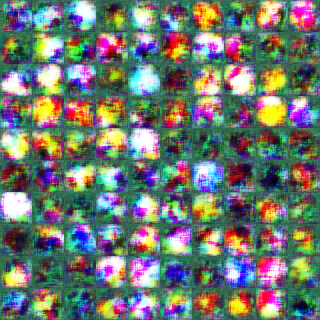



The features of these images are not clear at all. One can't tell what character is in each cell.

7800thg iteration

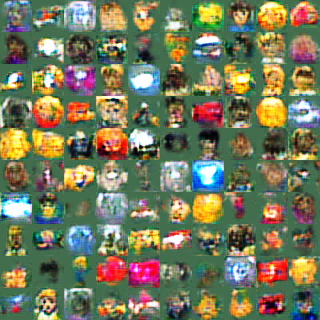

The features of these images are clearm and the details can also be seen. This image at the 7800th iteration have the best quality.

20000th Itertaion

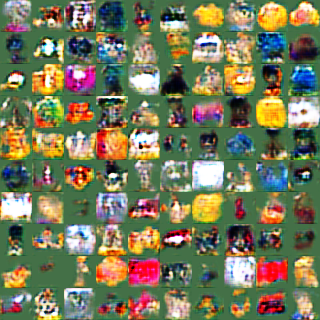

Although features of the characters can still be observed, there are less details compare to the image produced at the 7800th iteration.

Therefore, the performance of the GAN improves as iteration goes from 200 to some point, but then performance starts to drop afterwards.


## Part 2: Comparisons Between Least Square and Default Regular Training Loop

Loss Plot for Regular training loop

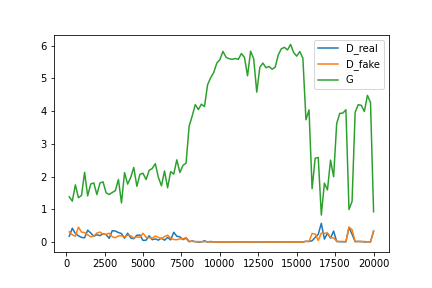

Loss Plot for Least Square

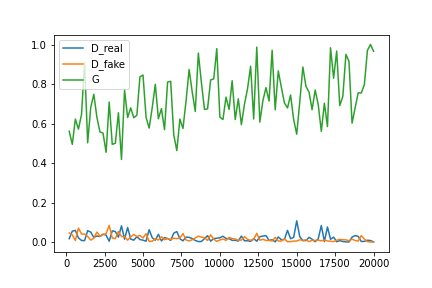

As you can see from the above plots, the training losses using the least square loss are more stable. This is because it provides more gradient information to the generator.